In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))

import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler

from src.modeling_functions import get_results,plot_roc_curve,plot_lime_explanation,fit_and_get_xgb_model,plot_xgb_feature_importance,plot_shap

c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load and split the data
data = pd.read_csv("../Data/Telco-Customer-Churn-Encoded.csv")
X = data.drop(columns='Churn')
y = data['Churn']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42,shuffle=True)

print("Churn Distribution:")
print(y_train.value_counts(normalize=True) * 100)

Churn Distribution:
Churn
0    73.425437
1    26.574563
Name: proportion, dtype: float64


In [3]:
# scale and resample the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

smote = SMOTE(random_state=42, sampling_strategy=0.6666,k_neighbors=2)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
X_train_smote = pd.DataFrame(X_train_smote, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)


print("Churn Distribution:")
print(y_train_smote.value_counts(normalize=True) * 100)

Churn Distribution:
Churn
0    60.003321
1    39.996679
Name: proportion, dtype: float64


In [4]:
# Fit the XGBoost model
model_xgb = fit_and_get_xgb_model(X_train_smote,y_train_smote,save_model=False)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 1, 'scale_pos_weight': 2, 'subsample': 0.8}
Best CV F1 Score: 0.7702550533842838


In [5]:
# Load the model
model_xgb = xgb.XGBClassifier()
model_xgb.load_model('../models/model_xgb.json')
y_pred = model_xgb.predict(X_test)
y_pred_train = model_xgb.predict(X_train_smote)

Metrics for test and train
Metrics for test
Accuracy: 0.7445
Precision: 0.5123
Recall: 0.8164
F1: 0.6296

Metrics for train
Accuracy: 0.8091
Precision: 0.7050
Recall: 0.8987
F1: 0.7901

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.72      0.81      1549
           1       0.51      0.82      0.63       561

    accuracy                           0.74      2110
   macro avg       0.71      0.77      0.72      2110
weighted avg       0.81      0.74      0.76      2110



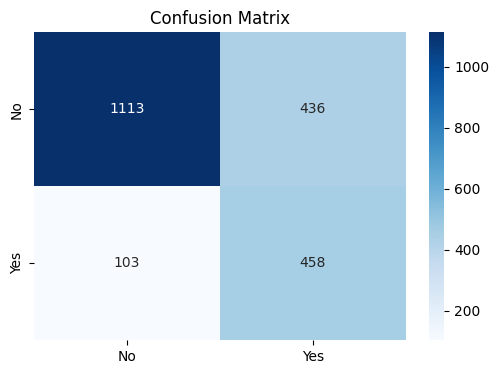

In [6]:
# Get metric results
get_results(y_test,y_pred,y_train_smote,y_pred_train)

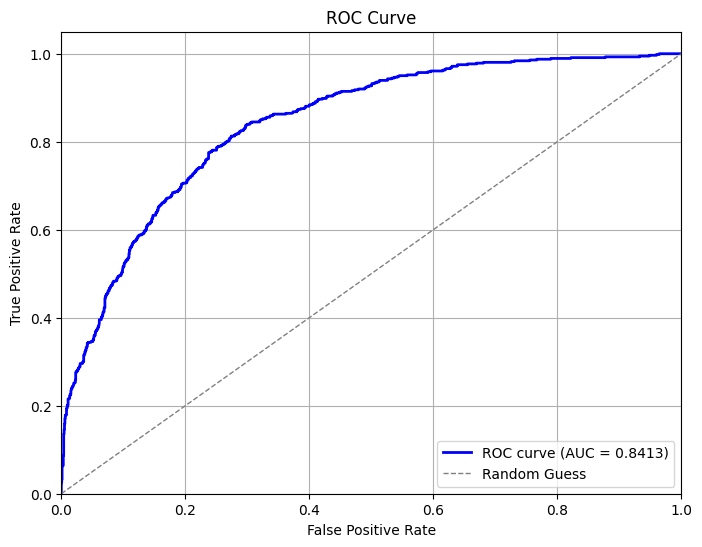

AUC: 0.8413


In [7]:
# Plot ROC curve
plot_roc_curve(model=model_xgb,X_test=X_test,y_test=y_test)

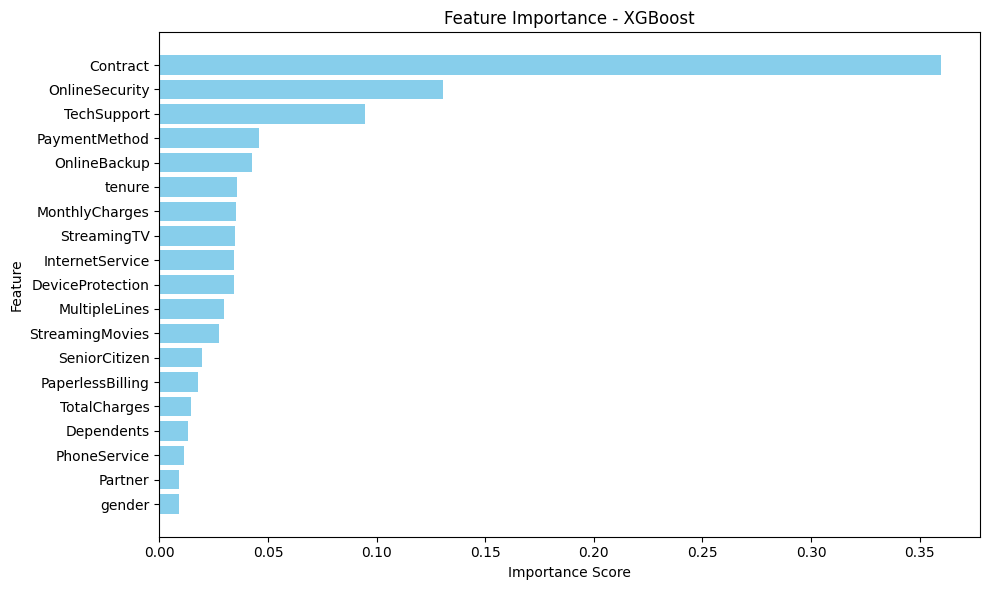

Feature Importance Scores:
             Feature  Importance
14          Contract    0.359768
8     OnlineSecurity    0.130567
11       TechSupport    0.094571
16     PaymentMethod    0.045865
9       OnlineBackup    0.042698
4             tenure    0.035789
17    MonthlyCharges    0.035129
12       StreamingTV    0.035006
7    InternetService    0.034545
10  DeviceProtection    0.034321
6      MultipleLines    0.029664
13   StreamingMovies    0.027424
1      SeniorCitizen    0.019763
15  PaperlessBilling    0.017744
18      TotalCharges    0.014512
3         Dependents    0.013285
5       PhoneService    0.011349
2            Partner    0.009204
0             gender    0.008797


In [8]:
# Plot Feature Importance
plot_xgb_feature_importance(model=model_xgb,X_train=X_train_smote)

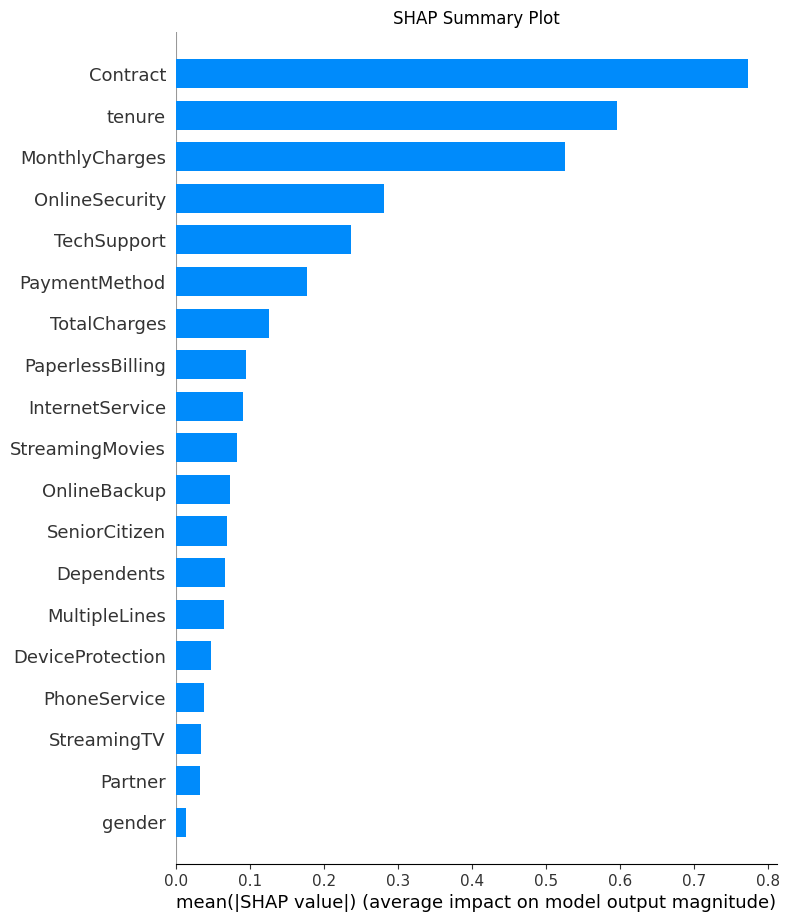

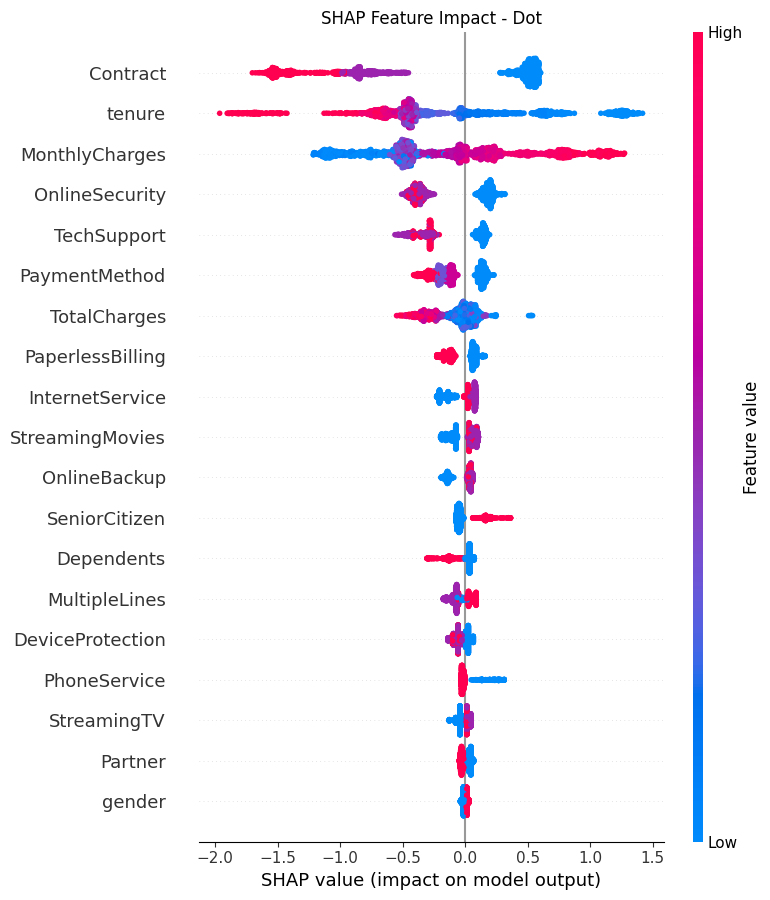

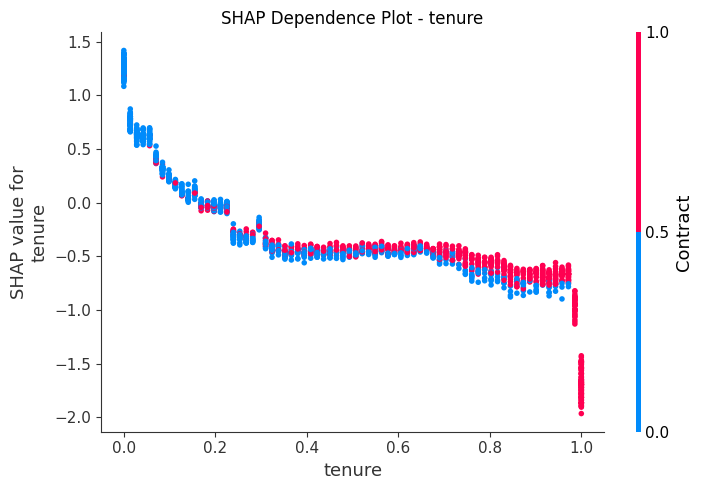

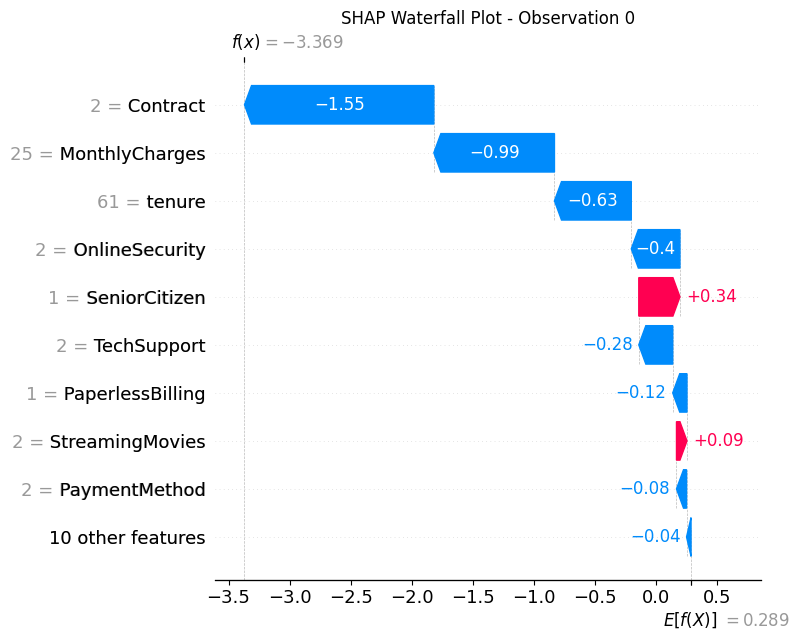

In [9]:
# Plot SHAP explanations
plot_shap(model=model_xgb,model_type='xgboost',scaler=scaler,X_test=X_test,feature_name='tenure',observation_idx=0)

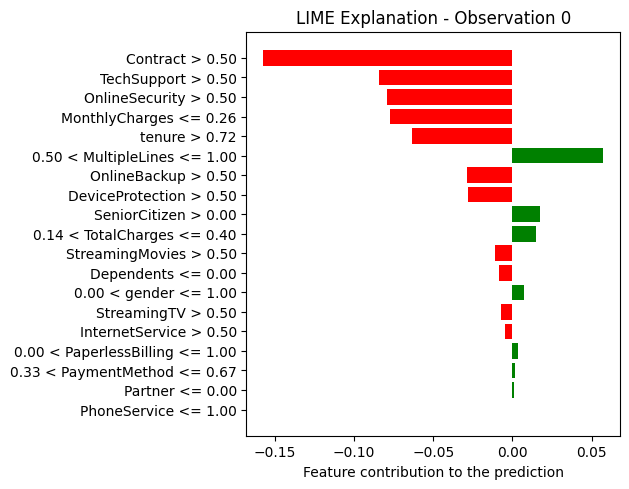

Predicted Probabilities: No Churn = 0.9667, Churn = 0.0333


In [10]:
# Plot LIME explanation for a specific instance
plot_lime_explanation(model=model_xgb,X_train=X_train_smote,X_test=X_test,observation_idx=0)